# Audio

This notebook is part of [_The Joy of Jupyter_](https://github.com/mwermelinger/The-Joy-of-Jupyter), an introduction on how to use Jupyter notebooks and what can be done with them. 

This notebook shows how to generate and manipulate sound using the [SciPy](https://www.scipy.org) and NumPy libraries. Note that NumPy arrays behave differently from Python lists. You may wish to use headphones for this notebook.

## 1. WAV Processing

This part is inspired by Daniel Zingaro's [_Stereo Sound Processing_](http://nifty.stanford.edu/2012/zingaro-stereo-sound-processing/) assignment, which has further details on how sound is digitally stored.

Take a sound file recorded by you or that has a license that allows manipulation, e.g. "Fast Talkin" by Kevin MacLeod ([incompetech.com](https://incompetech.com/music/)), licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/).

The original file is in MP3 format. It was converted to WAV using an MP3 player. Let's listen to it!

In [1]:
from IPython.display import Audio

TITLE = 'Fast_Talkin'
EXTENSION = '.wav'
ORIGINAL = TITLE + EXTENSION
Audio(ORIGINAL)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Oops, the file seems to be too large to be played. Let's check its size, in kilobytes.

In [2]:
!ls -sk "{ORIGINAL}"

10192 Fast_Talkin.wav


It's about 10 megabytes long. I'll shorten the sound to be played by loading the file into memory and then writing the first few seconds to a new WAV file.

A WAV file is a sequences of samples. Each sample is one (if mono) or two (if stereo) numbers representing the displacement of the left, right or single microphone's membrane at some point in time. By playing back the displacements through a loudspeaker membrane, we hear the recorded sound.

In [3]:
from scipy.io.wavfile import read, write
import numpy

rate, samples = read(ORIGINAL)

The rate is the number of samples recorded per second. 

In [4]:
rate

44100

Let's see the first few samples.

In [5]:
samples[:10]

array([[ 1, 15],
       [15, 28],
       [22, 29],
       [50, 77],
       [22, 28],
       [50, 59],
       [27, 26],
       [23, 38],
       [46, 55],
       [15,  7]], dtype=int16)

This gives us two pieces of information: 

- The sound is stereo because there are two different values for each sample.
- Each value is a 16-bit integer, i.e. from -32768 to 32767.

The duration of the sound can be easily computed.

In [6]:
len(samples) // rate

59

This piece of music is 59 seconds long. Let's take just the first 10 seconds and hope it's not too long to be played.

In [7]:
CLIP = TITLE + '_clip' + EXTENSION
write(CLIP, rate, samples[:10*rate])
Audio(CLIP, autoplay=True)

In [8]:
!ls -sk "{CLIP}"

1724 Fast_Talkin_clip.wav


As expected, the output file is one sixth of the size of the original file (10Mb / 6 = 1.7Mb) because the duration was reduced to a sixth (10 of 59 seconds, to be precise). 

**Activity:** Change the above code to play 10 other seconds from the music, e.g. from second 20 to second 30, or the last 10 seconds of the piece. There are at least two different ways of doing the latter.

**Activity:** Write the output file at a different rate, e.g. at half or double the original rate. What happens to the sound? What happens to the file size?

Let's make the volume louder and remove the right channel, to obtain a mono sound.  

In [9]:
# don't modify the original; instead copy 10s from the left channel
left = numpy.copy(samples[:10*rate, 0])
# increase volume by 50%
for sample in range(len(left)):
    left[sample] = left[sample] * 1.5
# write the left channel only
MODIFIED = TITLE + '_modified' + EXTENSION
write(MODIFIED, rate, left)
Audio(MODIFIED, autoplay=True)

**Activity:** Increase the volume by 150%. What happens to the sound and why? Change the code to avoid the problem. Hint: remember that each sample should be a 16-bit number.

I can't hear any difference between the stereo and mono files, other than the volume. It means the instruments are balanced over both channels. The file size has been halved without reduction in sound quality!

In [10]:
!ls -sk "{MODIFIED}"

 864 Fast_Talkin_modified.wav


Just to be sure, let me see the original sound waves for the left and right channels separately.

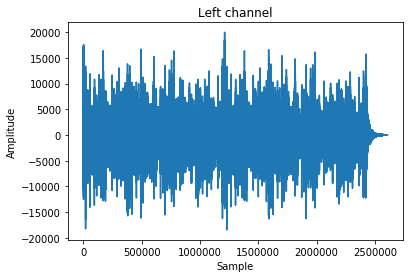

In [11]:
from matplotlib.pyplot import *
%matplotlib inline

title('Left channel')
plot(samples[:, 0])
xlabel('Sample')
ylabel('Amplitude')
show()

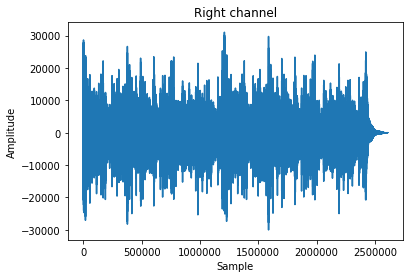

In [12]:
title('Right channel')
plot(samples[:, 1])
xlabel('Sample')
ylabel('Amplitude')
show()

Indeed very similar!

**Activity:** Change the code so that the first half is a fade-in and the second half a fade-out, i.e. the volume is uniformly increased from 0 to the original volume over the first 5 seconds and then decreases back to 0 in the next 5 seconds. 

**Activity:** Do the panning and voice cancellation exercises of Zingaro's assignment.

**Activity:** One way to compress a sound file so that it requires less space on disk is to keep only every _n_-th frame and correspondingly reduce the sampling rate to 1/_n_-th of the original rate. For example, by keeping only every second sample and reducing the rate to half, the output file will be half the size but the music will keep its duration and pitch. Write code that does such compression, given _n_. Try increasing values for _n_ until you find the sound quality unacceptable. Can you reduce the file size so that the notebook can play the whole 59 seconds?

## 2. Guitar

This part shows how to synthesise a note on a guitar using the Karplus-Strong algorithm. The [_Guitar Heroine_](http://nifty.stanford.edu/2012/wayne-guitar-heroine/) assignment developed by Kevin Wayne and colleagues provides more details on how and why the algorithm works.

The code below generates an ascending C-E-G major chord, with notes played 1 second after each other. Each note is generated separately, using the algorithm, and then they are combined into a single mono channel.

In [13]:
from random import randint

# the number of samples per second
RATE = 44100

def note(steps, silence_duration, note_duration):
    """Generate silence followed by a note for the given durations.
    The durations are in seconds.
    Steps is the number of half-steps from A4.
    Return a list of 16-bit samples.
    """
    # the frequency of the note on the equal-tempered scale
    FREQUENCY = 440 * 2 ** (steps / 12)
    # initially all samples are zero (no sound)
    samples = [0] * round(RATE / FREQUENCY)
    # the guitar string is plucked (random noise)
    for index in range(len(samples)):
        samples[index] = randint(-32768, 32767)
    # generate the sound for the required duration
    head = 0
    while len(samples) < note_duration * RATE:
        sample = round((samples[head] + samples[head+1]) / 2 * 0.994)
        samples.append(sample)
        head += 1
    return [0] * round(silence_duration * RATE) + samples

c = note(-21, 0, 4)  # C below middle C for a deeper sound
e = note(-17, 1, 3)  
g = note(-14, 2, 2)      

mono = [0] * len(c)
for index in range(len(mono)):
    mono[index] = (c[index] + e[index] + g[index]) // 3

Audio(mono, rate=RATE, autoplay=True)

**Activity:** Do a plot of the whole guitar sound, then of the first hundredth of a second (random noise for the C), and finally of the first fifth of a second. What can you observe?